На нескольких вариантах синтетического датасета натренеруйте любой детектор

In [ ]:
#@title Скрипты для обучения и тестирования из репозитория TorchVision
import os
from pathlib import Path

# Если директория "vision" не существует, то происходит клонирование репозитория
if not Path("vision").exists():
    # происходит клонирование репозитория "vision" из GitHub в текущую директорию.
    !git clone https://github.com/pytorch/vision.git
    # переход в директорию "vision"
    os.chdir("vision")
    # переключаем репозиторий на версию 0.15.2.
    !git checkout v0.15.2
    # копируем необходимые файлы из директории "references/detection" в родительскую директорию
    !cp references/detection/utils.py ../
    !cp references/detection/transforms.py ../
    !cp references/detection/coco_eval.py ../
    !cp references/detection/engine.py ../
    !cp references/detection/coco_utils.py ../
    # возврат в родительскую директорию
    os.chdir("..")

Cloning into 'vision'...
remote: Enumerating objects: 340994, done.
remote: Counting objects: 100% (76093/76093), done.
remote: Compressing objects: 100% (1436/1436), done.
remote: Total 340994 (delta 75234), reused 75356 (delta 74622), pack-reused 264901
Receiving objects: 100% (340994/340994), 686.04 MiB | 24.10 MiB/s, done.
Resolving deltas: 100% (314213/314213), done.
Note: switching to 'v0.15.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at fa99a5360f Remove temporary channel for python 3.11 (#7505) (#7

## Датасет

In [ ]:
#@title Вспомогательные функции
import cv2
import numpy as np

def visualize(image_np, bboxes, labels, thickness=2):
    # Create a copy of the image to draw on
    img_with_boxes = image_np.copy()

    # Draw bounding boxes
    colors = {1: (0, 255, 0), 2: (255, 0, 0), 3: (0, 0, 255)}
    for i, bbox in enumerate(bboxes):
        color=colors[labels[i]]
        x1, y1, x2, y2 = bbox
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, thickness)

    return img_with_boxes

In [ ]:
#@title Синтетический датасет

import numpy as np
import cv2
import random
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt


class RandomShapeDataset(Dataset):
    def __init__(self, num_samples,
                 num_shapes=3,
                 size_range=(5, 20),
                 canvas_size=(100, 100),
                 idx_to_class=None,
                 return_masks=False):
        self.num_samples = num_samples
        self.num_shapes = num_shapes
        self.size_range = size_range
        self.canvas_size = canvas_size
        self.idx_to_class = idx_to_class
        self.return_masks = return_masks
        if self.idx_to_class is None:
            self.idx_to_class = {1: 'triangle', 2: 'circle', 3: 'rectangle'}

        self.shape_types = list(self.idx_to_class.values())
        self.class_to_idx = {i: c for c, i in self.idx_to_class.items()}

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        canvas = np.zeros((*self.canvas_size, 3), dtype=np.uint8)
        if self.return_masks:
            masks = [np.zeros(self.canvas_size, dtype=np.uint8) for i in range(self.num_shapes)]
        bounding_boxes = []
        labels = []
        areas = []
        for i in range(self.num_shapes):
            shape_type = random.choice(self.shape_types)
            size = random.randint(*self.size_range)
            color = tuple(random.randint(0, 255) for _ in range(3))
            bounding_box = None
            if shape_type == 'triangle':
                points = self._random_triangle_points(size)
                cv2.fillPoly(canvas, [points], color)
                if self.return_masks:
                    cv2.fillPoly(masks[i], [points], 255)
                bounding_box = self._get_bounding_box(points)
            elif shape_type == 'circle':
                center, radius = self._random_circle_parameters(size)
                cv2.circle(canvas, center, radius, color, -1)
                if self.return_masks:
                    cv2.circle(masks[i], center, radius, 255, -1)
                bounding_box = self._get_circle_bounding_box(center, radius)
            elif shape_type == 'rectangle':
                x, y, w, h = self._random_rectangle_parameters(size)
                cv2.rectangle(canvas, (x, y), (x + w, y + h), color, -1)
                if self.return_masks:
                    cv2.rectangle(masks[i], (x, y), (x + w, y + h), 255, -1)
                bounding_box = np.array([x, y, x + w, y + h])
            labels.append(self.class_to_idx[shape_type])
            bounding_boxes.append(bounding_box)
            if self.return_masks:
                areas.append(np.sum(masks[i]))
            else:
                areas.append(1)
        bounding_boxes = np.stack(bounding_boxes, axis=0)
        target = dict(labels=torch.tensor(labels, dtype=torch.long),
                      boxes=torch.tensor(bounding_boxes, dtype=torch.float32),
                      image_id=torch.tensor([idx], dtype=torch.long),
                      area=torch.tensor(areas, dtype=torch.float32))
        if self.return_masks:
            masks=torch.tensor(masks, dtype=torch.float32)
            target["masks"] = masks

        return torch.tensor(canvas, dtype=torch.float32).permute(2, 0, 1)/255, target

    def _random_triangle_points(self, size):
        center = np.random.randint(size, self.canvas_size[0] - size, size=2)
        angle = np.random.uniform(0, 2 * np.pi)
        points = np.array([(np.cos(angle), np.sin(angle)),
        (np.cos(angle + 2 * np.pi / 3), np.sin(angle + 2 * np.pi / 3)),
        (np.cos(angle + 4 * np.pi / 3), np.sin(angle + 4 * np.pi / 3))])
        points = (size * points + center).astype(np.int32)
        return points.reshape(-1, 1, 2)

    def _random_circle_parameters(self, size):
        center = tuple(np.random.randint(size, self.canvas_size[0] - size, size=2))
        radius = random.randint(size // 4, size // 2)
        return center, radius

    def _random_rectangle_parameters(self, size):
        x, y = np.random.randint(size, self.canvas_size[0] - size, size=2)
        w, h = random.randint(size // 2, size), random.randint(size // 2, size)
        return (x, y, w, h)

    def _get_bounding_box(self, points):
        points = points.squeeze(1)
        min_coords = np.min(points, axis=0)
        max_coords = np.max(points, axis=0)
        res = np.concatenate([min_coords, max_coords], axis=0)

        return res

    def _get_circle_bounding_box(self, center, radius):
        min_coords = np.array(center) - radius
        max_coords = np.array(center) + radius
        res = np.concatenate([min_coords, max_coords], axis=0)
        return res

## Задания Lite

#### Датасет 1

Image shape: torch.Size([3, 64, 64])
Bounding boxes: torch.Size([1, 4])
Labels: tensor([1])


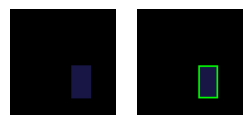

In [ ]:
dataset = RandomShapeDataset(num_samples=1000,
                             num_shapes=1,
                             size_range=(15, 30),
                             canvas_size=(64, 64),
                             idx_to_class={1: 'rectangle'})

image, target = dataset[0]
print("Image shape:", image.shape)
print("Bounding boxes:", target['boxes'].shape)
print("Labels:", target['labels'])

image_np = np.asarray(ToPILImage()(image))
image_np_vis = visualize(np.asarray(ToPILImage()(image)), target['boxes'].type(torch.int).numpy(), target['labels'].numpy(), thickness=1)

fig = plt.figure(figsize=(3, 3))
axis = fig.add_subplot(1, 2, 1)
axis.imshow(image_np)
axis.axis('off')
axis = fig.add_subplot(1, 2, 2)
axis.axis('off')
axis.imshow(image_np_vis)

Ваше решение:


##### Новая версия

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import utils
from tqdm.notebook import tqdm

def collate_fn(batch):  # Избавляемся в батче от поля image_path во время обучения
    # итерация по каждому элементу в "batch", а именно, для каждого элемента формируется новый кортеж,
    # который будет содержать первоначальный объект в позиции 0 и словарь в позиции 1.

    # Внутри формируемого словаря происходит удаление элемента "image_path" из первоначального словаря,
    # если такой ключ в нем был обнаружен.
    batch = [(sample[0], {k: v for k, v in sample[1].items() if k != "image_path"}) for sample in batch]

    # извлеченный список кортежей возвращается обратно в функцию "utils.collate_fn" для дальнейшей обработки.
    return utils.collate_fn(batch)

# Step 1: Define and load the detector model
model = fasterrcnn_resnet50_fpn(pretrained=True)
#num_classes = 4  # Background + triangle + circle + rectangle
num_classes = 2  # Background + rectangle
in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = nn.Linear(in_features, num_classes) - переделать
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Step 2: Prepare the dataset
#dataset = RandomShapeDataset(num_samples=1000, num_shapes=1, size_range=(15, 30), canvas_size=(64, 64))

# Step 3: Split the dataset into training and evaluation sets
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size])

# Step 4: Create data loaders for training and evaluation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn = collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn = collate_fn)

# Step 5: Configure training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

num_epochs = 3
i = 0  # Счетчик
# Step 6: Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        i += 1
        if i%100 == 0:
            print(losses.item())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 80.6MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker pro

  0%|          | 0/3 [00:00<?, ?it/s]

0.04099390283226967
0.025472644716501236
0.019662288948893547
0.009392913430929184
0.015545010566711426
0.011305502615869045


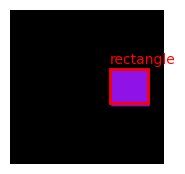

In [ ]:
# Step 7: Evaluation
model.eval()
with torch.no_grad():
    #for images, targets in eval_loader:
        images, targets = next(iter(eval_loader))
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Visualize the images with predicted bounding boxes
        #for i in range(len(images)):
        for i in range(1):
            image = images[i].cpu()
            target = targets[i]
            prediction = predictions[i]

            image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            image_pil = ToPILImage()(image_np)

            fig = plt.figure(figsize=(2, 2))
            axis = fig.add_subplot(1, 1, 1)
            axis.imshow(image_pil)
            axis.axis('off')

            boxes = prediction['boxes'].cpu().numpy().astype(np.int32)
            labels = prediction['labels'].cpu().numpy()
            for box, label in zip(boxes, labels):
                x, y, x_max, y_max = box
                rect = plt.Rectangle((x, y), x_max - x, y_max - y, fill=False, edgecolor='red', linewidth=2)
                axis.add_patch(rect)

                # Check if the label exists in the dictionary
                if label in dataset.idx_to_class:
                    axis.text(x, y - 2, dataset.idx_to_class[label], color='red')
                #else:
                #    axis.text(x, y, "", color='red')

            plt.show()


## Подготовка пакетов

#### Датасет 2

Image shape: torch.Size([3, 64, 64])
Bounding boxes: torch.Size([3, 4])
Labels: tensor([1, 1, 1])


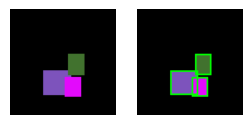

In [ ]:
dataset = RandomShapeDataset(num_samples=1000,
                             num_shapes=3,
                             size_range=(15, 30),
                             canvas_size=(64, 64),
                             idx_to_class={1: 'rectangle'})
image, target = dataset[0]
print("Image shape:", image.shape)
print("Bounding boxes:", target['boxes'].shape)
print("Labels:", target['labels'])

image_np = np.asarray(ToPILImage()(image))
image_np_vis = visualize(np.asarray(ToPILImage()(image)), target['boxes'].type(torch.int).numpy(), target['labels'].numpy(), thickness=1)

fig = plt.figure(figsize=(3, 3))
axis = fig.add_subplot(1, 2, 1)
axis.imshow(image_np)
axis.axis('off')
axis = fig.add_subplot(1, 2, 2)
axis.axis('off')
axis.imshow(image_np_vis)

Ваше решение:


##### Новая версия

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import utils
from tqdm.notebook import tqdm

def collate_fn(batch):  # Избавляемся в батче от поля image_path во время обучения
    # итерация по каждому элементу в "batch", а именно, для каждого элемента формируется новый кортеж,
    # который будет содержать первоначальный объект в позиции 0 и словарь в позиции 1.

    # Внутри формируемого словаря происходит удаление элемента "image_path" из первоначального словаря,
    # если такой ключ в нем был обнаружен.
    batch = [(sample[0], {k: v for k, v in sample[1].items() if k != "image_path"}) for sample in batch]

    # извлеченный список кортежей возвращается обратно в функцию "utils.collate_fn" для дальнейшей обработки.
    return utils.collate_fn(batch)

# Step 1: Define and load the detector model
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # Background + rectangle
in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = nn.Linear(in_features, num_classes) - переделать
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Step 2: Prepare the dataset
#dataset = RandomShapeDataset(num_samples=1000, num_shapes=1, size_range=(15, 30), canvas_size=(64, 64))

# Step 3: Split the dataset into training and evaluation sets
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size])

# Step 4: Create data loaders for training and evaluation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn = collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn = collate_fn)

# Step 5: Configure training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

num_epochs = 5
i = 0  # Счетчик
# Step 6: Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        i += 1
        if i%100 == 0:
            print(losses.item())

  0%|          | 0/5 [00:00<?, ?it/s]

0.2703617513179779
0.19736477732658386
0.22209466993808746
0.17416492104530334
0.3253535032272339
0.1964678317308426
0.1921648383140564
0.142782524228096
0.1721183955669403
0.25189435482025146


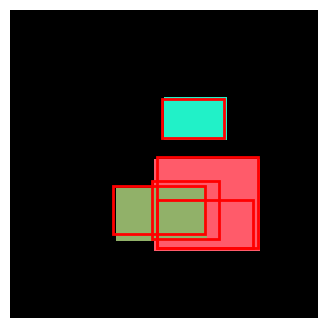

In [ ]:
# Step 7: Evaluation
model.eval()
with torch.no_grad():
    #for images, targets in eval_loader:
        images, targets = next(iter(eval_loader))
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Visualize the images with predicted bounding boxes
        #for i in range(len(images)):
        for i in range(1):
            image = images[i].cpu()
            target = targets[i]
            prediction = predictions[i]

            image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            image_pil = ToPILImage()(image_np)

            fig = plt.figure(figsize=(4, 4))
            axis = fig.add_subplot(1, 1, 1)
            axis.imshow(image_pil)
            axis.axis('off')

            boxes = prediction['boxes'].cpu().numpy().astype(np.int32)
            labels = prediction['labels'].cpu().numpy()
            for box, label in zip(boxes, labels):
                x, y, x_max, y_max = box
                rect = plt.Rectangle((x, y), x_max - x, y_max - y, fill=False, edgecolor='red', linewidth=2)
                axis.add_patch(rect)

                # Check if the label exists in the dictionary
                #if label in dataset.idx_to_class:
                #    axis.text(x, y - 2, dataset.idx_to_class[label], color='red')
                #else:
                #    axis.text(x, y, "", color='red')

            plt.show()


#### Датасет 3

Image shape: torch.Size([3, 128, 128])
Bounding boxes: torch.Size([3, 4])
Labels: tensor([1, 1, 1])


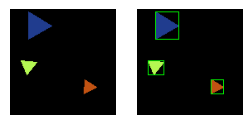

In [ ]:
dataset = RandomShapeDataset(num_samples=1000,
                             num_shapes=3,
                             size_range=(10, 20),
                             canvas_size=(128, 128),
                             idx_to_class={1: 'triangle'})
image, target = dataset[0]
print("Image shape:", image.shape)
print("Bounding boxes:", target['boxes'].shape)
print("Labels:", target['labels'])

image_np = np.asarray(ToPILImage()(image))
image_np_vis = visualize(np.asarray(ToPILImage()(image)), target['boxes'].type(torch.int).numpy(), target['labels'].numpy(), thickness=1)

fig = plt.figure(figsize=(3, 3))
axis = fig.add_subplot(1, 2, 1)
axis.imshow(image_np)
axis.axis('off')
axis = fig.add_subplot(1, 2, 2)
axis.axis('off')
axis.imshow(image_np_vis)

Ваше решение:


##### Новая версия

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import utils
from tqdm.notebook import tqdm

def collate_fn(batch):  # Избавляемся в батче от поля image_path во время обучения
    # итерация по каждому элементу в "batch", а именно, для каждого элемента формируется новый кортеж,
    # который будет содержать первоначальный объект в позиции 0 и словарь в позиции 1.

    # Внутри формируемого словаря происходит удаление элемента "image_path" из первоначального словаря,
    # если такой ключ в нем был обнаружен.
    batch = [(sample[0], {k: v for k, v in sample[1].items() if k != "image_path"}) for sample in batch]

    # извлеченный список кортежей возвращается обратно в функцию "utils.collate_fn" для дальнейшей обработки.
    return utils.collate_fn(batch)

# Step 1: Define and load the detector model
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # Background + triangle
in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = nn.Linear(in_features, num_classes) - переделать
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Step 2: Prepare the dataset
#dataset = RandomShapeDataset(num_samples=1000, num_shapes=1, size_range=(15, 30), canvas_size=(64, 64))

# Step 3: Split the dataset into training and evaluation sets
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size])

# Step 4: Create data loaders for training and evaluation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn = collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn = collate_fn)

# Step 5: Configure training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

num_epochs = 5
i = 0  # Счетчик
# Step 6: Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        i += 1
        if i%100 == 0:
            print(losses.item())

  0%|          | 0/5 [00:00<?, ?it/s]

0.10767002403736115
0.16751304268836975
0.0898347795009613
0.06589614599943161
0.05036981403827667
0.12176474928855896
0.16014008224010468
0.1043446809053421
0.06325382739305496
0.06189559027552605


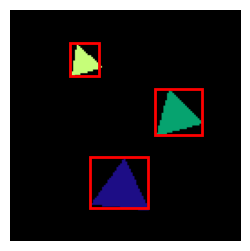

In [ ]:
# Step 7: Evaluation
model.eval()
with torch.no_grad():
    #for images, targets in eval_loader:
        images, targets = next(iter(eval_loader))
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Visualize the images with predicted bounding boxes
        #for i in range(len(images)):
        for i in range(1):
            image = images[i].cpu()
            target = targets[i]
            prediction = predictions[i]

            image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            image_pil = ToPILImage()(image_np)

            fig = plt.figure(figsize=(3, 3))
            axis = fig.add_subplot(1, 1, 1)
            axis.imshow(image_pil)
            axis.axis('off')

            boxes = prediction['boxes'].cpu().numpy().astype(np.int32)
            labels = prediction['labels'].cpu().numpy()
            for box, label in zip(boxes, labels):
                x, y, x_max, y_max = box
                rect = plt.Rectangle((x, y), x_max - x, y_max - y, fill=False, edgecolor='red', linewidth=2)
                axis.add_patch(rect)

                # Check if the label exists in the dictionary
                #if label in dataset.idx_to_class:
                #    axis.text(x, y - 2, dataset.idx_to_class[label], color='red')
                #else:
                #    axis.text(x, y, "", color='red')

            plt.show()


#### Датасет 4

Image shape: torch.Size([3, 160, 160])
Bounding boxes: torch.Size([3, 4])
Labels: tensor([2, 2, 3])


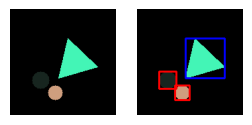

In [ ]:
dataset = RandomShapeDataset(num_samples=1000,
                             num_shapes=3,
                             size_range=(30, 45),
                             canvas_size=(160, 160),
                             idx_to_class={1: 'rectangle', 2: 'circle', 3: 'triangle'})
image, target = dataset[0]
print("Image shape:", image.shape)
print("Bounding boxes:", target['boxes'].shape)
print("Labels:", target['labels'])

image_np = np.asarray(ToPILImage()(image))
image_np_vis = visualize(np.asarray(ToPILImage()(image)), target['boxes'].type(torch.int).numpy(), target['labels'].numpy(), thickness=2)

fig = plt.figure(figsize=(3, 3))
axis = fig.add_subplot(1, 2, 1)
axis.imshow(image_np)
axis.axis('off')
axis = fig.add_subplot(1, 2, 2)
axis.axis('off')
axis.imshow(image_np_vis)

Ваше решение:


##### Новая версия

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import utils
from tqdm.notebook import tqdm

def collate_fn(batch):  # Избавляемся в батче от поля image_path во время обучения
    # итерация по каждому элементу в "batch", а именно, для каждого элемента формируется новый кортеж,
    # который будет содержать первоначальный объект в позиции 0 и словарь в позиции 1.

    # Внутри формируемого словаря происходит удаление элемента "image_path" из первоначального словаря,
    # если такой ключ в нем был обнаружен.
    batch = [(sample[0], {k: v for k, v in sample[1].items() if k != "image_path"}) for sample in batch]

    # извлеченный список кортежей возвращается обратно в функцию "utils.collate_fn" для дальнейшей обработки.
    return utils.collate_fn(batch)

# Step 1: Define and load the detector model
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 4  # Background + triangle + rectangle + circle
in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = nn.Linear(in_features, num_classes) - переделать
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Step 2: Prepare the dataset
#dataset = RandomShapeDataset(num_samples=1000, num_shapes=1, size_range=(15, 30), canvas_size=(64, 64))

# Step 3: Split the dataset into training and evaluation sets
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size])

# Step 4: Create data loaders for training and evaluation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn = collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn = collate_fn)

# Step 5: Configure training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

num_epochs = 5
i = 0  # Счетчик
# Step 6: Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        i += 1
        if i%100 == 0:
            print(losses.item())

  0%|          | 0/5 [00:00<?, ?it/s]

0.242594376206398
0.2898567020893097
0.15614470839500427
0.08539005368947983
0.15878137946128845
0.17711448669433594
0.18530337512493134
0.21091656386852264
0.13706637918949127
0.0904151052236557


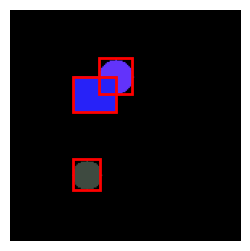

In [ ]:
# Step 7: Evaluation
model.eval()
with torch.no_grad():
    #for images, targets in eval_loader:
        images, targets = next(iter(eval_loader))
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Visualize the images with predicted bounding boxes
        #for i in range(len(images)):
        for i in range(1):
            image = images[i].cpu()
            target = targets[i]
            prediction = predictions[i]

            image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            image_pil = ToPILImage()(image_np)

            fig = plt.figure(figsize=(3, 3))
            axis = fig.add_subplot(1, 1, 1)
            axis.imshow(image_pil)
            axis.axis('off')

            boxes = prediction['boxes'].cpu().numpy().astype(np.int32)
            labels = prediction['labels'].cpu().numpy()
            for box, label in zip(boxes, labels):
                x, y, x_max, y_max = box
                rect = plt.Rectangle((x, y), x_max - x, y_max - y, fill=False, edgecolor='red', linewidth=2)
                axis.add_patch(rect)

                # Check if the label exists in the dictionary
                #if label in dataset.idx_to_class:
                #    axis.text(x, y - 2, dataset.idx_to_class[label], color='red')
                #else:
                #    axis.text(x, y, "", color='red')

            plt.show()


**Выводы:** 1, 3, 4 Datasets, в принципе, отработали норимально - минус медленная скорость обучения. Это говорит о неоптимальности модели, но все имеет право на жизнь. Что касается 2 Dataset - сколько ни запускал, низкая, по сравнению с другими, точность и наличие, всегда, дополнительных рамок, может это связано с тем, что прямоугольники перекрываются и модель начинает "путаться" при определении границ фигур, а, возможно, имеются ошибки в отрисовке результата.

## Задания Pro

#### Датасет 5

Image shape: torch.Size([3, 800, 800])
Bounding boxes: torch.Size([300, 4])
Labels: torch.Size([300])


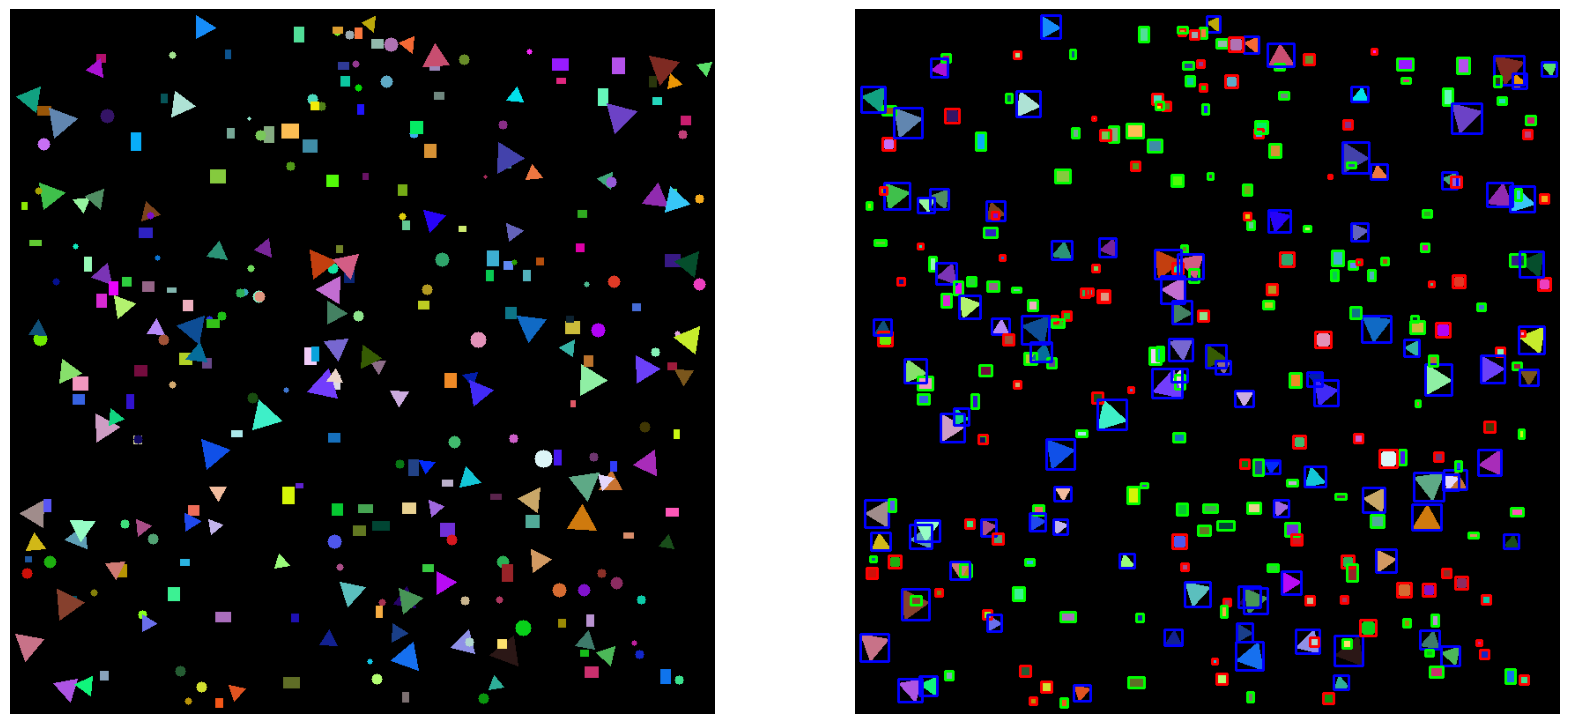

In [ ]:
dataset = RandomShapeDataset(num_samples=1000,
                             num_shapes=300,
                             size_range=(10, 20),
                             canvas_size=(800, 800),
                             idx_to_class={1: 'rectangle', 2: 'circle', 3: 'triangle'})
image, target = dataset[0]
print("Image shape:", image.shape)
print("Bounding boxes:", target['boxes'].shape)
print("Labels:", target['labels'].shape)

image_np = np.asarray(ToPILImage()(image))
image_np_vis = visualize(np.asarray(ToPILImage()(image)), target['boxes'].type(torch.int).numpy(), target['labels'].numpy(), thickness=2)

fig = plt.figure(figsize=(20, 20))
axis = fig.add_subplot(1, 2, 1)
axis.imshow(image_np)
axis.axis('off')
axis = fig.add_subplot(1, 2, 2)
axis.axis('off')
axis.imshow(image_np_vis)

Ваше решение:


##### Новая версия

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import utils
from tqdm.notebook import tqdm

def collate_fn(batch):  # Избавляемся в батче от поля image_path во время обучения
    # итерация по каждому элементу в "batch", а именно, для каждого элемента формируется новый кортеж,
    # который будет содержать первоначальный объект в позиции 0 и словарь в позиции 1.

    # Внутри формируемого словаря происходит удаление элемента "image_path" из первоначального словаря,
    # если такой ключ в нем был обнаружен.
    batch = [(sample[0], {k: v for k, v in sample[1].items() if k != "image_path"}) for sample in batch]

    # извлеченный список кортежей возвращается обратно в функцию "utils.collate_fn" для дальнейшей обработки.
    return utils.collate_fn(batch)

# Step 1: Define and load the detector model
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 4  # Background + triangle + rectangle + circle
in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = nn.Linear(in_features, num_classes) - переделать
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Step 2: Prepare the dataset
#dataset = RandomShapeDataset(num_samples=1000, num_shapes=1, size_range=(15, 30), canvas_size=(64, 64))

# Step 3: Split the dataset into training and evaluation sets
train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size])

# Step 4: Create data loaders for training and evaluation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn = collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn = collate_fn)

# Step 5: Configure training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

num_epochs = 20
i = 0  # Счетчик
# Step 6: Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        i += 1
        if i%100 == 0:
            print(losses.item())

  0%|          | 0/20 [00:00<?, ?it/s]

0.6599763631820679
0.5266627073287964
0.5021195411682129
0.453302264213562
0.40437063574790955
0.40302160382270813
0.4227346181869507
0.4058549106121063
0.4144161343574524
0.39083507657051086
0.415164589881897
0.38715997338294983
0.3885825276374817
0.36170870065689087
0.3570464253425598
0.3368107080459595
0.350949764251709
0.3185068964958191
0.3222060203552246
0.32509416341781616
0.3134045898914337
0.3054167628288269
0.33270132541656494
0.31723490357398987
0.26924264430999756
0.2907615900039673
0.30616047978401184
0.3058292865753174
0.3067188858985901
0.29261264204978943
0.3137975037097931
0.2825237512588501
0.26876264810562134
0.2874152362346649
0.26700717210769653
0.2699018716812134
0.33291736245155334
0.2731058597564697
0.2927853465080261
0.2620583772659302


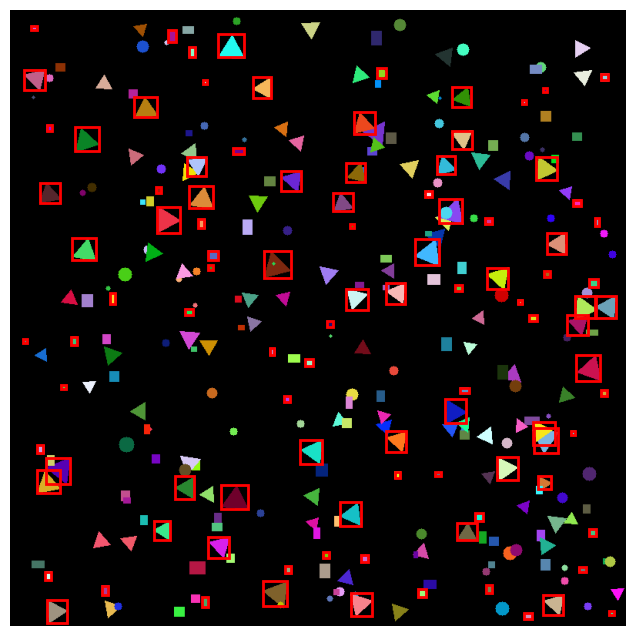

In [ ]:
# Step 7: Evaluation
model.eval()
with torch.no_grad():
    #for images, targets in eval_loader:
        images, targets = next(iter(eval_loader))
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Make predictions
        predictions = model(images)

        # Visualize the images with predicted bounding boxes
        #for i in range(len(images)):
        for i in range(1):
            image = images[i].cpu()
            target = targets[i]
            prediction = predictions[i]

            image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            image_pil = ToPILImage()(image_np)

            fig = plt.figure(figsize=(8, 8))
            axis = fig.add_subplot(1, 1, 1)
            axis.imshow(image_pil)
            axis.axis('off')

            boxes = prediction['boxes'].cpu().numpy().astype(np.int32)
            labels = prediction['labels'].cpu().numpy()
            for box, label in zip(boxes, labels):
                x, y, x_max, y_max = box
                rect = plt.Rectangle((x, y), x_max - x, y_max - y, fill=False, edgecolor='red', linewidth=2)
                axis.add_patch(rect)

                # Check if the label exists in the dictionary
                #if label in dataset.idx_to_class:
                #    axis.text(x, y - 2, dataset.idx_to_class[label], color='red')
                #else:
                #    axis.text(x, y, "", color='red')

            plt.show()


Конечно, данная модель не очень хорошо отработала, но задача по точности не ставилась, а в качестве модели исследования, видно, что возможно, дело в функции ошибки, т.к. ошибка прыгает, но в целом уменьшается. Из минусов - низкая скорость обучения.